# This notebook helps to visualize the shift between two arc calibration frames

Notebook will read in a txt file containing a list of arc frames (see sampleFileList.txt for proper formatting) and plot their shift compared to the first arc listed.

The plots are interactive and clicking on a specific line will tell you it's position on the chip, wavelength, and shift 

In [1]:
#Installation of necessary extensions 
import sys
!{sys.executable} -m pip install mplcursors
!{sys.executable} -m pip install ipympl

In [15]:

from astropy.io import fits
import numpy as np
from scipy.optimize import curve_fit
from math import log
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import pandas as pd
import mplcursors
from matplotlib.backend_bases import MouseButton
#If plots are not interactive changing "notebook" to "widget" may solve the issue
%matplotlib notebook 


## File Input Required!

In [16]:
dir = '/home/matt/HAACode/CompareShift/fileListBlueTest.txt' #Path to list of arcs 
baseData = fits.open('/home/matt/GHOSTDR/ghostdr/ghost/lookups/Polyfit/blue/high/220620/wavemod.fits') #Path to blue or red wavemod
thardata_full = np.genfromtxt('/home/matt/GHOSTDR/ghostdr/ghost/lookups/Polyfit/ghost_thar_linelist_20220718.txt', usecols=(1,), dtype=None, encoding=None) #Path to default linelist
camera = 'blue'

In [17]:
def findRange(line, waveList, data):
    inRange = []
    for wavelength in waveList:
        if wavelength >= line-0.18 and wavelength <= line+0.18:
            #print(wavelength, data[np.where(waveList == wavelength)][0], np.where(waveList == wavelength))
            inRange.append([wavelength, data[np.where(waveList == wavelength)][0]])

    if len(inRange) != 0:
        return inRange
    else:
        return None

def gauss(x, a, b, sigma):
    return a*np.exp(-(x-b)**2/(2*sigma**2))

def mase(actual : np.ndarray, predicted : np.ndarray):

    forecast_error = np.mean(np.abs(actual - predicted))
    naive_forecast = np.mean(np.abs(np.diff(actual)))
    mase = forecast_error / naive_forecast

    return mase

def findIndex(arr, selX, selY):
    tmpX = tmpY = tmpI = 0
    for i, list in enumerate(arr):
        if (tmpX > abs(list[1] - selX) and tmpY > abs(list[2] - selY)) or (tmpX == 0 and tmpY == 0):
            tmpX = abs(list[1] - selX)   
            tmpY = abs(list[2] - selY)   
            tmpI = i
    return tmpI
    




Checking flagged lines for 22/09/13...


/home/matt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



Checking flagged lines for 22/09/16...

Checking flagged lines for 22/09/14...


<IPython.core.display.Javascript object>


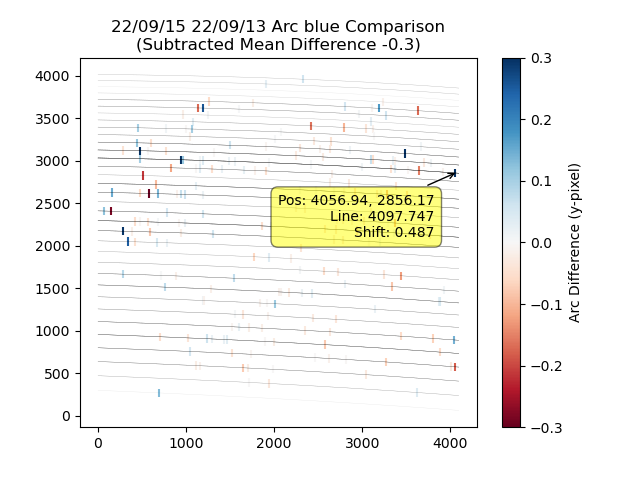

<IPython.core.display.Javascript object>


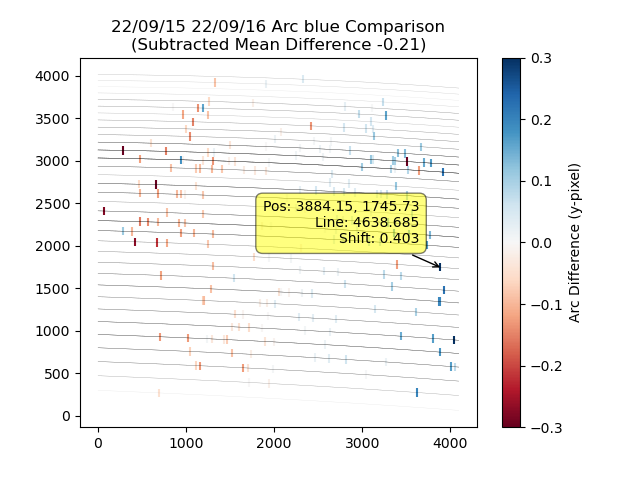

<IPython.core.display.Javascript object>


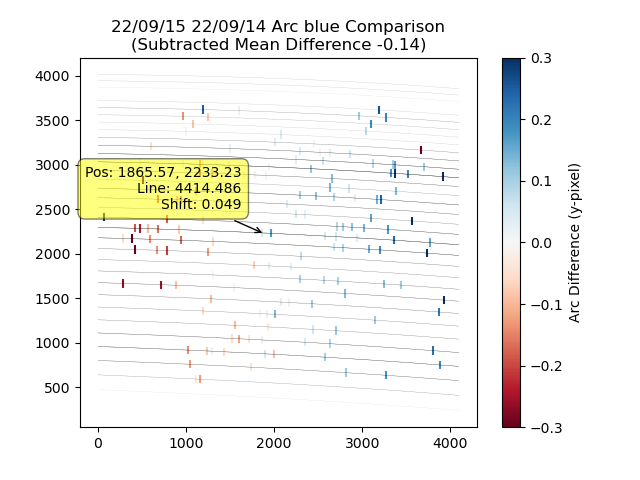

In [18]:

dateList = np.genfromtxt(dir, usecols=(0,), dtype=None, encoding=None)
flatList = np.genfromtxt(dir, usecols=(1,), dtype=None, encoding=None)
arcList = np.genfromtxt(dir, usecols=(2,), dtype=None, encoding=None)
residList = np.genfromtxt(dir, usecols=(3,), dtype=None, encoding=None)
flat1Data = fits.open(flatList[0])
arc1Data = fits.open(arcList[0])
thar1data = np.genfromtxt(residList[0], usecols=(0,), dtype=None, encoding=None)
baseWavemod = baseData[0].data
xmod1 = flat1Data[4].data
arc1Wavemod = arc1Data[4].data
baseDate = dateList[0]
y1primes = np.arange(arc1Data[1].data.shape[1])
plotList= []
lineData = []


for i, (date, flat, arc, resid) in enumerate(zip(dateList[1:], flatList[1:], arcList[1:], residList[1:]), start=1): 
    
    
    #Initializing Variables
    flat2Data = fits.open(flat)
    arc2Data = fits.open(arc)
    arcDate = date
    thar2data = np.genfromtxt(resid, usecols=(0,), dtype=None, encoding=None)
    arc2Wavemod = arc2Data[4].data
    xmod2 = flat2Data[4].data
    commonLineList = list(set(thar1data).intersection(thar2data))
    if camera == 'blue':
        wavelengths = np.arange(3475, 5480, 20)
        m_ref = 80
    else:
        wavelengths = np.arange(5100, 10700, 20)
        m_ref = 50

    # Initializing lists 
    plotData = []
    flagged = []
    lineList = []
    for index, wavelength in enumerate(wavelengths):
        plot_id = (index % 5) + 1
        
        presentLines = thardata_full[(thardata_full < wavelength + 10) & (thardata_full > wavelength-10)]  

        for i in range(arc1Data[1].data.shape[0]):
            
            if camera == 'blue':
                m = i + 64
                poly_arc1_model = np.poly1d([np.poly1d(arc1Wavemod[i,:])((m_ref/m)-1) for i in range(len(arc1Wavemod[:,0]))])
                poly_arc2_model = np.poly1d([np.poly1d(arc2Wavemod[i,:])((m_ref/m)-1) for i in range(len(arc2Wavemod[:,0]))])
                poly_xmod1_model = np.poly1d([np.poly1d(xmod1[i,:])((m_ref/m)-1) for i in range(len(xmod1[:,0]))])
                poly_xmod2_model = np.poly1d([np.poly1d(xmod2[i,:])((m_ref/m)-1) for i in range(len(xmod2[:,0]))])
                wave1 = poly_arc1_model(y1primes- 4096//2)
                wave2 = poly_arc2_model(y1primes- 4096//2)
                xval1 = poly_xmod1_model(y1primes- 4096//2) + 4112//2
                xval2 = poly_xmod2_model(y1primes- 4096//2) + 4112//2
            else:
                m = i + 33
                poly_arc1_model = np.poly1d([np.poly1d(arc1Wavemod[i,:])((m_ref/m)-1) for i in range(len(arc1Wavemod[:,0]))])
                poly_arc2_model = np.poly1d([np.poly1d(arc2Wavemod[i,:])((m_ref/m)-1) for i in range(len(arc2Wavemod[:,0]))])
                poly_xmod1_model = np.poly1d([np.poly1d(xmod1[i,:])((m_ref/m)-1) for i in range(len(xmod1[:,0]))])
                poly_xmod2_model = np.poly1d([np.poly1d(xmod2[i,:])((m_ref/m)-1) for i in range(len(xmod2[:,0]))])
                wave1 = poly_arc1_model(y1primes- 6144//2)
                wave2 = poly_arc2_model(y1primes- 6144//2)
                xval1 = poly_xmod1_model(y1primes- 6144//2) + 6160//2
                xval2 = poly_xmod2_model(y1primes- 6144//2) + 6160//2


            data1 = arc1Data[1].data[i,:,0]
            data2 = arc2Data[1].data[i,:,0]
            
            for line in presentLines:
                if line in commonLineList: 

                    arc1MaxFlux = arc1MaxWave = arc2MaxFlux = arc2MaxWave = 0                    
                    arc1Range = np.array(findRange(line, wave1, data1))
                    arc2Range = np.array(findRange(line, wave2, data2))

                    if (arc1Range == None).any() or (arc2Range == None).any() or len(arc1Range[:,0]) < 5:
                        break
                    else:  
                        arc1WaveData, arc1FluxData = arc1Range[:,0], arc1Range[:,1]
                        arc2WaveData, arc2FluxData = arc2Range[:,0], arc2Range[:,1]

                        #Determining initial guess for line position 
                        for num1 in arc1WaveData:
                            arc1TempFlux = float(data1[np.where(wave1==num1)])
                            if arc1MaxFlux < arc1TempFlux or arc1MaxFlux == 0:
                                arc1MaxFlux = arc1TempFlux
                                arc1MaxWave = num1   
                        for num2 in arc2WaveData:
                            arc2TempFlux = float(data2[np.where(wave2==num2)])
                            if arc2MaxFlux < arc2TempFlux or arc2MaxFlux == 0:
                                arc2MaxFlux = arc2TempFlux
                                arc2MaxWave = num2   
                        
                        #Fitting gaussian to data
                        y1Data = []
                        y2Data = []
                        x1Data = []
                        for i in arc1WaveData:
                            y1Data.append((y1primes[np.where(wave1==i)])[0])
                            x1Data.append((xval1[np.where(wave1==i)])[0])

                        for i in arc2WaveData:
                            y2Data.append((y1primes[np.where(wave2==i)])[0])
                        
                        try:
                            yprimeParams1, p_covy1 = curve_fit(gauss, y1Data, arc1FluxData, p0=((arc1MaxFlux, (y1primes[np.where(wave1==arc1MaxWave)])[0], 1)), maxfev=10000)
                            xvalParams1, p_covx1 = curve_fit(gauss, x1Data, arc1FluxData, p0=((arc1MaxFlux, (xval1[np.where(wave1==arc1MaxWave)])[0], 1)), maxfev=10000)
                            yprimeParams2, p_covy2 = curve_fit(gauss, y2Data, arc2FluxData, p0=((arc2MaxFlux, (y1primes[np.where(wave2==arc2MaxWave)])[0], 1)), maxfev=10000)
                            waveParams1, p_covw1 = curve_fit(gauss, arc1WaveData, arc1FluxData, p0=((arc1MaxFlux, arc1MaxWave, 0.03)), maxfev=10000)
                            waveParams2, p_covw2 = curve_fit(gauss, arc2WaveData, arc2FluxData, p0=((arc2MaxFlux, arc2MaxWave, 0.03)), maxfev=10000)
                        except RuntimeError:
                            break

                        else:
                            #Determine width of lines in wavelength and pixels
                            fwhm1 = abs(waveParams1[2]*np.sqrt(8*log(2)))
                            fwhm2 = abs(waveParams2[2]*np.sqrt(8*log(2)))
                            fwhmPixel1 = abs(yprimeParams1[2]*np.sqrt(8*log(2)))
                            fwhmPixel2 = abs(yprimeParams2[2]*np.sqrt(8*log(2)))
                            
                            #Determine error in the fit 
                            y1FitError = gauss(y1Data, yprimeParams1[0], yprimeParams1[1], yprimeParams1[2])
                            y2FitError = gauss(y2Data, yprimeParams2[0], yprimeParams2[1], yprimeParams2[2])
                            arc1fitError = mase(arc1FluxData, y1FitError)
                            arc2fitError = mase(arc2FluxData, y2FitError)
                                    
                            plotData.append([line, yprimeParams1[1], xvalParams1[1], yprimeParams1[1]-yprimeParams2[1], fwhm1, fwhm2, arc1fitError, arc2fitError])
                                
                    #Plot traces of the order
                    lineList.append([y1primes, xval1]) 
                    #, color='black', linewidth=0.25, alpha=0.1)
            
    lineData.append(lineList)
    
    plotArr = np.array(plotData)

    avgFitError1 = np.mean(plotArr[:,6])
    fitErrorSTD1 = np.std(plotArr[:,6])
    avgFitError2 = np.mean(plotArr[:,7])
    fitErrorSTD2 = np.std(plotArr[:,7])

    #Finding fwhm for lines that fit well
    findFWHM1 = []
    findFWHM2 = []
    for i in range(plotArr.shape[0]):
        if plotArr[i,6] < 0.1:
            findFWHM1.append(plotArr[i,4])
        if plotArr[i,7] < 0.1:
            findFWHM2.append(plotArr[i,5])
    avgFWHM1 = np.mean(findFWHM1)
    fwhmSTD1 = np.std(findFWHM1)
    avgFWHM2 = np.mean(findFWHM2)
    fwhmSTD2 = np.std(findFWHM2)

    fwhmDiff = abs(avgFWHM1 - avgFWHM2)
    fwhmDiffSTD = abs(fwhmSTD1 - fwhmSTD2)


    #Filtering poor lines / noisy data
    print(f"\nChecking flagged lines for {arcDate}...")
    filteredData = []
    for i in range(plotArr.shape[0]):
        #Checks if fit error is less that 0.1 for both arcs
        if plotArr[i,6] < 0.1 and plotArr[i,7] < 0.1:
            filteredData.append([plotArr[i,0], plotArr[i,1], plotArr[i,2], plotArr[i,3], plotArr[i,0]/plotArr[i,4]])
        else:
            #Checks if the fwhm is around the average
            if avgFWHM1-(1-fwhmSTD1/avgFWHM1)/20 < plotArr[i,4] < avgFWHM1+(1-fwhmSTD1/avgFWHM1)/8 and avgFWHM2-(1-fwhmSTD2/avgFWHM2)/20 < plotArr[i,5] < avgFWHM2+(1-fwhmSTD2/avgFWHM2)/8:
                #Checks if the fit error is around the average                
                if plotArr[i,6] <= avgFitError1+(fitErrorSTD1/avgFitError1)/2 and plotArr[i,7] <= avgFitError2+(fitErrorSTD2/avgFitError2)/2:    
                    #Checks if the fwhm difference is around the average                
                    if abs(plotArr[i,4] - plotArr[i,5]) < fwhmDiff+10*fwhmDiffSTD:
                        filteredData.append([plotArr[i,0], plotArr[i,1], plotArr[i,2], plotArr[i,3], plotArr[i,0]/plotArr[i,4]])           
                    else:
                        flagged.append([plotArr[i,0], plotArr[i,1], plotArr[i,2], plotArr[i,3], plotArr[i,0]/plotArr[i,4]])
                else:
                    flagged.append([plotArr[i,0], plotArr[i,1], plotArr[i,2], plotArr[i,3], plotArr[i,0]/plotArr[i,4]])
            else:
                flagged.append([plotArr[i,0], plotArr[i,1], plotArr[i,2], plotArr[i,3], plotArr[i,0]/plotArr[i,4]])
                
    plot1Arr = np.array(filteredData)
    newFlagArr = np.array(flagged)
    avgShift = np.mean(plot1Arr[:,3])
    shiftSTD = np.std(plot1Arr[:,3])
    plotList.append([plot1Arr, avgShift, baseDate, arcDate])


#print(lineData[0][0])
data = np.array(lineData, dtype = object)
#print((data[0])[:,0])
#Plotting chip with lines and shift
for i, (arr, shift, bDate, aDate) in enumerate(plotList):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    for j in range(len(lineData[i])):
        plot2 = ax1.plot((data[i])[j][0], (data[i])[j][1], color='black', linewidth=0.25, alpha=0.1)
    plot1 = ax1.scatter(arr[:,1], arr[:,2] - shift, marker = '|', c=(arr[:,3] - shift), cmap='RdBu', vmin=-0.3, vmax=0.3, label=i)
    ax1.set_title(f'{bDate} {aDate} Arc {camera} Comparison\n(Subtracted Mean Difference {round(shift,2)})')
    cb = plt.colorbar(plot1, label='Arc Difference (y-pixel)')
    lgnd = plt.legend()
    ax1.get_legend().remove()
    crs = mplcursors.cursor(plot1)
    @crs.connect("add")
    def add(sel):
        for i in range(len(plotList)):
            arr = np.array(plotList, dtype=object)
            if int(sel.artist.get_label()) == i:
                index = findIndex((arr[i])[0], sel.target[0], sel.target[1])
                sel.annotation.set_text(
                    'Pos: {}, {}\nLine: {}\nShift: {}'.format(round(sel.target[0],2), round(sel.target[1],2), round(((arr[i])[0])[index, 0], 3), round(((arr[i])[0])[index, 3] - (arr[i])[1], 3)))
        


plt.show()
